In [1]:
!pip install --upgrade gspread

  Found existing installation: gspread 3.0.1
    Uninstalling gspread-3.0.1:
      Successfully uninstalled gspread-3.0.1


In [2]:
import pandas as pd
# from datetime import datetime
import matplotlib.pyplot as plt

###Import data

#Question 1
1. As is shown in Figure 1 and Figure 2, both order_amount and total_items have significant outliers. This might have caused the erroneous AOV calculation. 
2. Because each shop sells a different type of model, I analyzed the data by shop_id and found that user 607 who shopped in shop 42 bought 2000 items for each order.
3. After verfying the unit price of one pair of sneakers of the same model is the same, I found another outlier: model in shop 78 is sold at $25725. 

4. There doesn't seem to be anything wrong with the data entry given that the unit price of the same model is the same. A possible explanation for outlier 1 is that a particular customer bought the sneakers wholesale at shop 42. For outlier 2, the sneakers at shop 78 are a fancy model. 
5. After remving the outliers, AOV drops to $320.58, which seems reasonable.

6. Instead of looking at the average order value, we could look at the medium value and the quantile to get a sense of the date without having to cleanse the outliers. The medium order value is $284.


In [3]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())
worksheet = gc.open('2019 Winter Data Science Intern Challenge Data Set').sheet1

In [4]:
# get_all_values gives a list of rows.
rows = worksheet.get_all_values()
#print(rows)

# Convert to a DataFrame and render.
df = pd.DataFrame.from_records(rows)
df.columns = df.iloc[0]
df.index = df.iloc[:,0]
df = df.iloc[1:,1:]
pd.set_option('display.max_colwidth',-1)
df.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  # Remove the CWD from sys.path while we load stuff.


,shop_id,user_id,order_amount,total_items,payment_method,created_at
order_id,,,,,,
1,53,746,224,2,cash,2017-03-13 12:36:56
2,92,925,90,1,cash,2017-03-03 17:38:52
3,44,861,144,1,cash,2017-03-14 4:23:56
4,18,935,156,1,credit_card,2017-03-26 12:43:37
5,18,883,156,1,credit_card,2017-03-01 4:35:11
6,58,882,138,1,credit_card,2017-03-14 15:25:01
7,87,915,149,1,cash,2017-03-01 21:37:57
8,22,761,292,2,cash,2017-03-08 2:05:38
9,64,914,266,2,debit,2017-03-17 20:56:50


###Clean and format data.

In [5]:
df['date'] = pd.to_datetime(df['created_at'], format='%Y-%m-%d %H:%M:%S').dt.date
df['hour'] = pd.to_datetime(df['created_at'], format='%Y-%m-%d %H:%M:%S').dt.hour

In [12]:
df[['user_id','shop_id','date']].describe()

,user_id,shop_id,date
count,5000,5000,5000
unique,301,100,30
top,718,53,2017-03-09
freq,28,68,199


In [21]:
df['order_amount'] = df['order_amount'].apply(lambda x: int(x))
df['total_items'] = df['total_items'].apply(lambda x: int(x))
df['shop_id'] = df['shop_id'].apply(lambda x: int(x))
df[['order_amount', 'total_items']].describe()

,order_amount,total_items
count,5000.000000,5000.00000
mean,3145.128000,8.78720
std,41282.539349,116.32032
min,90.000000,1.00000
25%,163.000000,1.00000
50%,284.000000,2.00000
75%,390.000000,3.00000
max,704000.000000,2000.00000


###Look for outliers.

(array([4.937e+03, 0.000e+00, 1.900e+01, 0.000e+00, 0.000e+00, 1.600e+01,
        0.000e+00, 9.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]),
 array([     0,  10000,  20000,  30000,  40000,  50000,  60000,  70000,
         80000,  90000, 100000, 110000, 120000, 130000, 140000, 150000,
        160000, 170000, 180000, 190000, 200000, 210000, 220000, 230000,
        240000, 250000, 260000, 270000, 280000, 290000]),
 <a list of 29 Patch objects>)

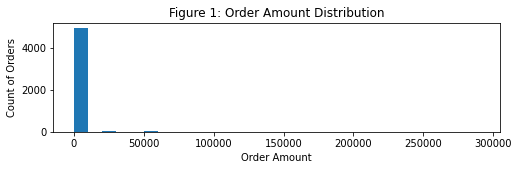

In [62]:
plt.figure(figsize=(8,2))
plt.title('Figure 1: Order Amount Distribution')
plt.xlabel('Order Amount')
plt.ylabel('Count of Orders')
bins_list1 = [i*10000 for i in range(30)]
plt.hist(df['order_amount'], bins=bins_list1)

(array([4983.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,   17.]),
 array([   0,  100,  200,  300,  400,  500,  600,  700,  800,  900, 1000,
        1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000]),
 <a list of 20 Patch objects>)

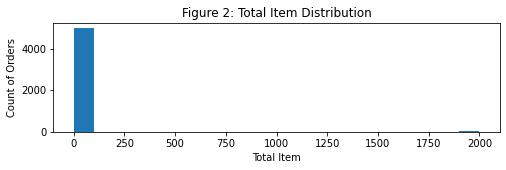

In [63]:
plt.figure(figsize=(8,2))
plt.title('Figure 2: Total Item Distribution')
plt.xlabel('Total Item')
plt.ylabel('Count of Orders')
bins_list2 = [i*100 for i in range(21)]
plt.hist(df['total_items'], bins=bins_list2)

###Analyze by shop_id.

In [34]:
df_shop = df.groupby('shop_id')[['order_amount','total_items']].describe().sort_index()
df_shop

0       order_amount                                 ... total_items                
               count        mean         std    min  ...         25%  50%   75%  max
shop_id                                              ...                            
1        44.0         308.818182  117.816032  158.0  ...  1.0         2.0  2.00  4.0
2        55.0         174.327273  91.204909   94.0   ...  1.0         2.0  2.00  5.0
3        48.0         305.250000  141.253130  148.0  ...  1.0         2.0  3.00  4.0
4        51.0         258.509804  103.956793  128.0  ...  1.0         2.0  3.00  4.0
5        45.0         290.311111  148.176771  142.0  ...  1.0         2.0  3.00  5.0
...       ...                ...         ...    ...  ...  ...         ...   ...  ...
96       51.0         330.000000  162.993620  153.0  ...  1.0         2.0  3.00  5.0
97       48.0         324.000000  160.267330  162.0  ...  1.0         2.0  3.00  5.0
98       58.0         245.362069  124.070961  133.0  ...  1.0         2.0  2.00  4.0
99       54.0         339.444444  161.536451  195.0  ...  1.0         2.0  2.00  4.0
100      40.0         213.675000  104.815195  111.0  ...  1.0         2.0  2.25  4.0

[100 rows x 16 columns]

###Outlier 1: A particular shop sells an average of 668 pairs of sneakers.

In [38]:
df_shop.total_items['mean'].unique()

array([  1.95454545,   1.85454545,   2.0625    ,   2.01960784,
         2.04444444,   2.05084746,   1.94642857,   1.82608696,
         1.98305085,   2.24528302,   1.93877551,   1.75471698,
         2.15873016,   2.0862069 ,   2.01923077,   1.73170732,
         1.88679245,   2.19607843,   1.96875   ,   1.98076923,
         2.17391304,   1.875     ,   2.03636364,   2.29090909,
         1.79166667,   1.98148148,   1.95348837,   2.03448276,
         1.92857143,   2.08510638,   1.88095238,   2.175     ,
         1.92      ,   2.        ,   1.96      ,   2.39583333,
         2.05714286,   1.83333333,   2.15254237, 667.90196078,
         1.84482759,   1.82051282,   1.89655172,   2.09302326,
         1.78723404,   2.075     ,   2.16981132,   2.09090909,
         1.93478261,   2.17073171,   1.91176471,   2.08      ,
         1.91666667,   1.86486486,   2.01886792,   1.84745763,
         2.01666667,   1.9787234 ,   2.18      ,   1.93023256,
         1.94827586,   2.04651163,   2.14814815,   1.94

####Find the shop_id: 42

In [41]:
df_shop[df_shop.total_items['mean']>667]

0       order_amount                                ... total_items                
               count           mean            std  ...         50%     75%     max
shop_id                                             ...                            
42       51.0         235101.490196  334860.641587  ...  2.0         2000.0  2000.0

[1 rows x 16 columns]

In [42]:
df[df['shop_id']==42]

,shop_id,user_id,order_amount,total_items,payment_method,created_at,date,hour
order_id,,,,,,,,
16,42,607,704000,2000,credit_card,2017-03-07 4:00:00,2017-03-07,4
41,42,793,352,1,credit_card,2017-03-24 14:15:41,2017-03-24,14
61,42,607,704000,2000,credit_card,2017-03-04 4:00:00,2017-03-04,4
309,42,770,352,1,credit_card,2017-03-11 18:14:39,2017-03-11,18
410,42,904,704,2,credit_card,2017-03-04 14:32:58,2017-03-04,14
521,42,607,704000,2000,credit_card,2017-03-02 4:00:00,2017-03-02,4
835,42,792,352,1,cash,2017-03-25 21:31:25,2017-03-25,21
836,42,819,704,2,cash,2017-03-09 14:15:15,2017-03-09,14
939,42,808,1056,3,credit_card,2017-03-13 23:43:45,2017-03-13,23


####Outlier1: User 607 who shopped in shop 42 bought 2000 items for each order.

In [48]:
df[(df['shop_id']==42) & (df['total_items']==2000)]

,shop_id,user_id,order_amount,total_items,payment_method,created_at,date,hour
order_id,,,,,,,,
16,42,607,704000,2000,credit_card,2017-03-07 4:00:00,2017-03-07,4
61,42,607,704000,2000,credit_card,2017-03-04 4:00:00,2017-03-04,4
521,42,607,704000,2000,credit_card,2017-03-02 4:00:00,2017-03-02,4
1105,42,607,704000,2000,credit_card,2017-03-24 4:00:00,2017-03-24,4
1363,42,607,704000,2000,credit_card,2017-03-15 4:00:00,2017-03-15,4
1437,42,607,704000,2000,credit_card,2017-03-11 4:00:00,2017-03-11,4
1563,42,607,704000,2000,credit_card,2017-03-19 4:00:00,2017-03-19,4
1603,42,607,704000,2000,credit_card,2017-03-17 4:00:00,2017-03-17,4
2154,42,607,704000,2000,credit_card,2017-03-12 4:00:00,2017-03-12,4


###Check if one shop has more than one unit price and find out the unit price for each model.

In [30]:
model_price = {}
for (shop_id, order_amount, total_items) in df[['shop_id','order_amount','total_items']].itertuples(index=False):
  price = order_amount/total_items
  if shop_id not in model_price:
    model_price[shop_id] = []
    model_price[shop_id].append(price)
  else:
    if price not in model_price[shop_id]:
      model_price[shop_id].append(price)

In [31]:
model_price

{1: [158.0],
 2: [94.0],
 3: [148.0],
 4: [128.0],
 5: [142.0],
 6: [187.0],
 7: [112.0],
 8: [132.0],
 9: [118.0],
 10: [148.0],
 11: [184.0],
 12: [201.0],
 13: [160.0],
 14: [116.0],
 15: [153.0],
 16: [156.0],
 17: [176.0],
 18: [156.0],
 19: [163.0],
 20: [127.0],
 21: [142.0],
 22: [146.0],
 23: [156.0],
 24: [140.0],
 25: [130.0],
 26: [176.0],
 27: [169.0],
 28: [164.0],
 29: [163.0],
 30: [153.0],
 31: [129.0],
 32: [101.0],
 33: [173.0],
 34: [122.0],
 35: [164.0],
 36: [130.0],
 37: [142.0],
 38: [190.0],
 39: [134.0],
 40: [161.0],
 41: [118.0],
 42: [352.0],
 43: [181.0],
 44: [144.0],
 45: [142.0],
 46: [166.0],
 47: [145.0],
 48: [117.0],
 49: [129.0],
 50: [193.0],
 51: [187.0],
 52: [146.0],
 53: [112.0],
 54: [133.0],
 55: [171.0],
 56: [117.0],
 57: [147.0],
 58: [138.0],
 59: [178.0],
 60: [177.0],
 61: [158.0],
 62: [160.0],
 63: [136.0],
 64: [133.0],
 65: [154.0],
 66: [161.0],
 67: [131.0],
 68: [136.0],
 69: [131.0],
 70: [173.0],
 71: [164.0],
 72: [160.0],
 7

####Outlier 2: Model in shop 78 is sold at $25725.

In [43]:
df[df['shop_id']==78].describe()

,shop_id,order_amount,total_items,hour
count,46.0,46.000000,46.000000,46.000000
mean,78.0,49213.043478,1.913043,12.543478
std,0.0,26472.227449,1.029047,6.702260
min,78.0,25725.000000,1.000000,1.000000
25%,78.0,25725.000000,1.000000,7.000000
50%,78.0,51450.000000,2.000000,12.500000
75%,78.0,51450.000000,2.000000,18.750000
max,78.0,154350.000000,6.000000,23.000000


###Remove the outliers.

In [58]:
df_new = df[(df['shop_id']!=78) & (df['user_id']!='607')]
df_new.describe()

,shop_id,order_amount,total_items,hour
count,4937.000000,4937.000000,4937.000000,4937.000000
mean,49.846465,302.580514,1.994734,11.425157
std,29.061131,160.804912,0.982821,6.961264
min,1.000000,90.000000,1.000000,0.000000
25%,24.000000,163.000000,1.000000,5.000000
50%,50.000000,284.000000,2.000000,11.000000
75%,74.000000,387.000000,3.000000,17.000000
max,100.000000,1760.000000,8.000000,23.000000


#Question 2

a. SELECT COUNT(*) FROM [Shippers],[Orders]
Where Shippers.ShipperID = Orders.ShipperID AND Shippers.ShipperName = 'Speedy Express'
Answer: 54

b. SELECT LastName FROM [Employees] Join [Orders] ON Employees.EmployeeID=Orders.EmployeeID ORDER BY Orders.OrderDate DESC

Answer: Callahan

c. SELECT ProductName, COUNT(*) FROM [Products] JOIN [Orders] ON Products.ProductID = OrderDetails.ProductID JOIN [OrderDetails] ON OrderDetails.OrderID = Orders.OrderID JOIN [Customers] ON Orders.CustomerID = Customers.CustomerID WHERE Customers.Country = 'Germany' GROUP BY Products.ProductID ORDER BY COUNT(*) DESC

Answer: Gorgonzola Telino